### KNN을 적용한 분류 예측.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import metrics, preprocessing
warnings.filterwarnings(action='ignore')                  # Turn off the warnings.
%matplotlib inline

#### 1. 데이터를 읽어온다.

데이터에 대한 설명은 [여기](https://www.kaggle.com/c/titanic/data) (로그인 필요)를 참고 한다.

In [2]:
df = pd.read_csv(r'data\data_titanic.csv', header='infer')

In [3]:
df.shape

(891, 12)

In [4]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### 2. 결측치 처리.

In [5]:
# 결측치 확인.
df.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# Age 변수의 결측치 채워 넣기.
n = df.shape[0]
Age = []                                                               # A temporary list.
for i in range(n):
    if np.isnan(df.Age[i]):
        if ('Mr' in df.Name[i]) or ('Mrs' in df.Name[i]) :
            Age.append(30)                                             # If Mr. or Mrs. in the name, then fill with 30.
        else:
            Age.append(10)                                             # Likely a child. So, fill with 10.
    else:
        Age.append(df.Age[i])
df.Age = pd.Series(Age)

In [7]:
# 불필요 컬럼 제외.
df = df.drop(columns = ['PassengerId','Name','Ticket','Fare','Cabin'])
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S


In [8]:
# 나머지 결측치 있는 행 소거.
df=df.dropna(axis=0)
df.shape

(889, 7)

In [9]:
df.shape

(889, 7)

#### 3. 탐색적 데이터 분석.

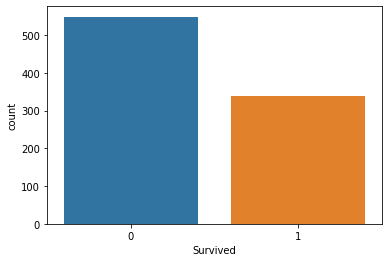

In [10]:
# Survived의 도수표.
sns.countplot('Survived',data=df)
plt.show()

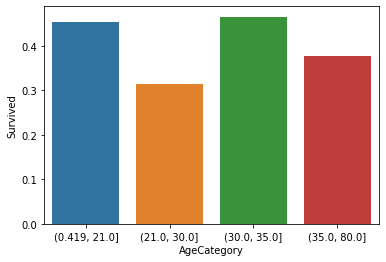

In [11]:
# Age 카테고리 별 생존률.
df['AgeCategory'] = pd.qcut(df.Age,4)                   # Using quantiles cut into 4 intervals.
sns.barplot(x='AgeCategory',y='Survived', ci=None, data=df)
plt.show()

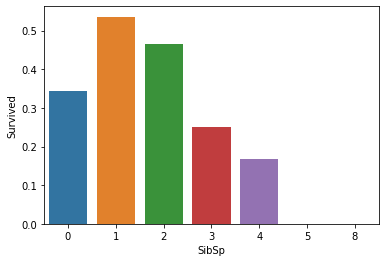

In [12]:
# SibSp 카테고리 별 생존률.
sns.barplot(x='SibSp', y='Survived', ci=None, data=df)
plt.show()

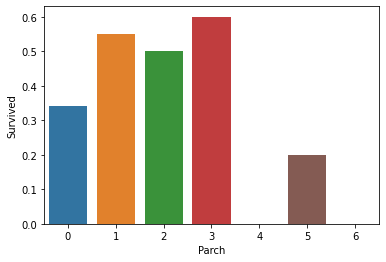

In [13]:
# Parch 카테고리 별 생존률.
sns.barplot(x='Parch', y='Survived', ci=None, data=df)
plt.show()

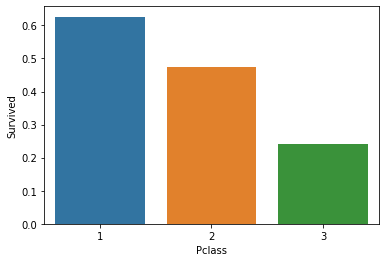

In [14]:
# Pclass 카테고리 별 생존률.
sns.barplot(x='Pclass', y='Survived', ci=None, data=df)
plt.show()

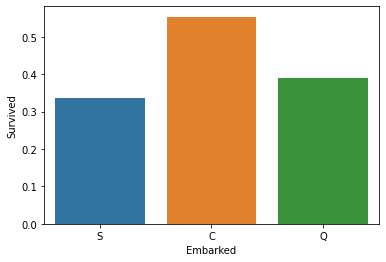

In [15]:
# Embarked 카테고리 별 생존률.
sns.barplot(x='Embarked', y='Survived', ci=None, data=df)
plt.show()

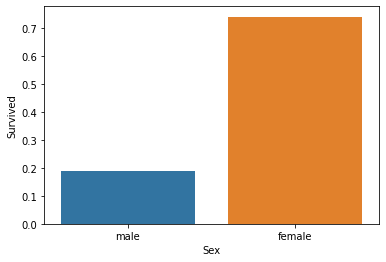

In [16]:
# Sex 카테고리 별 생존률.
sns.barplot(x='Sex', y='Survived', ci=None,  data=df)
plt.show()

#### 4. Feature Engineering.

In [17]:
# 명목형 변수를 더미변수로 변환 후 원 변수 소거.
df = pd.get_dummies(df.AgeCategory, drop_first=True,prefix='Age').join(df.drop(columns=['Age','AgeCategory']))
df = pd.get_dummies(df.Pclass, drop_first=True,prefix='Pclass').join(df.drop(columns=['Pclass']))
df = pd.get_dummies(df.SibSp, drop_first=True,prefix='SibSp').join(df.drop(columns=['SibSp']))
df = pd.get_dummies(df.Parch, drop_first=True,prefix='Parch').join(df.drop(columns=['Parch']))
df = pd.get_dummies(df.Sex, drop_first=True,prefix='Sex').join(df.drop(columns=['Sex']))
df = pd.get_dummies(df.Embarked, drop_first=True,prefix='Embarked').join(df.drop(columns=['Embarked']))
df.head(5)

,Embarked_Q,Embarked_S,Sex_male,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,SibSp_1,...,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Pclass_2,Pclass_3,"Age_(21.0, 30.0]","Age_(30.0, 35.0]","Age_(35.0, 80.0]",Survived
0,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [18]:
# 외부 파일로 저장.
df.to_csv(r'data\data_titanic_2.csv',index=False)

#### 5. KNN Train과 Test.

In [19]:
X = df.drop(columns=['Survived'])
Y = df.Survived

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(622, 20)
(267, 20)
(622,)
(267,)


In [22]:
# KNN with n_neighbours = 5
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, Y_train);
Y_pred = knn5.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

[[141  17]
 [ 36  73]]
------------------------
Accuracy : 0.801


In [23]:
# KNN with n_neighbours = 100
knn100 = KNeighborsClassifier(n_neighbors=100)
knn100.fit(X_train, Y_train);
Y_pred = knn100.predict(X_test)
print(metrics.confusion_matrix(Y_test,Y_pred))
print("------------------------")
print( "Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

[[157   1]
 [ 61  48]]
------------------------
Accuracy : 0.768


#### 6. KNN Bias-Variance Tradeoff. 

In [24]:
accs = []
k_grid = range(1,100,2)
for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accs.append(metrics.accuracy_score(Y_test,Y_pred))

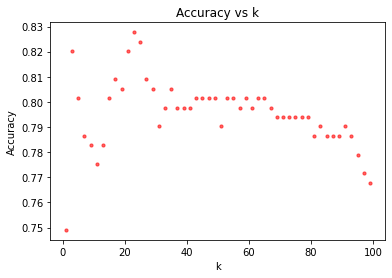

In [25]:
# 시각화.
plt.scatter(k_grid,accs,c='red',marker='o',s=10,alpha=0.6)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs k')
plt.show()

#### 7. KNN 하이퍼 파라미터 최적화.

In [26]:
# 파라미터 범위.
k_grid = np.arange(1,51,1)
parameters = {'n_neighbors':k_grid}

In [27]:
# k 최적화.
gridCV = GridSearchCV(KNeighborsClassifier(), parameters, cv=10, n_jobs = -1)       # "n_jobs = -1" means "use all the CPU cores".
gridCV.fit(X_train, Y_train)
best_k = gridCV.best_params_['n_neighbors']
print("Best k : " + str(best_k))

Best k : 37


In [28]:
# 최적화된 k를 사용한 예측.
#KNN_best = KNeighborsClassifier(n_neighbors=best_k)            # 최적의 하이퍼 파라미터를 사용해서 학습객체 재생성.
#KNN_best.fit(X_train, Y_train)
KNN_best = gridCV.best_estimator_                               # 교차검증의 결과인 최적의 학습객체 사용.
Y_pred = KNN_best.predict(X_test)
print( "Best Accuracy : " + str(np.round(metrics.accuracy_score(Y_test,Y_pred),3)))

Best Accuracy : 0.798
